In [1]:
#Cell 1: Imports & Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

SAVE_DIR = "Saved_files_new"


## Plotting functions

In [2]:
#Cell 2: Robust Data Loading Functions
def try_read_csv(file_path, sep_choices=(';', ',')):
    """Try to read CSV with different separators for robustness."""
    for sep in sep_choices:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if len(df.columns) == 1 and ',' in df.columns[0]:
                continue
            return df
        except Exception:
            continue
    raise ValueError(f"Could not load {file_path} with any separator.")

def load_complete_analysis_data(date_string, save_dir="Saved_files_new"):
    """Load analyzed DataFrame and, if present, topic names/keywords."""
    print(f"Loading complete analysis data for {date_string}...")
    try:
        for base in [
            f"semantic_scholar_{date_string}_all_results.csv",
            f"semantic_scholar_{date_string}_enhanced_analysis.csv",
            f"semantic_scholar_{date_string}_results.csv"
        ]:
            df_filename = os.path.join(save_dir, base)
            if os.path.exists(df_filename):
                break
        else:
            raise FileNotFoundError("No analyzed CSV file found.")
        df_analyzed = try_read_csv(df_filename)
        topic_keywords = topic_names = None
        topic_json_filename = os.path.join(save_dir, f"topics_{date_string}.json")
        if os.path.exists(topic_json_filename):
            with open(topic_json_filename, 'r', encoding='utf-8') as f:
                topic_meta = json.load(f)
                topic_keywords = topic_meta['topics']
                topic_names = topic_meta.get('topic_names', None)
        if not topic_names:
            for nm in [
                f"topic_names_{date_string}.json",
                f"semantic_scholar_{date_string}_topic_names.json"
            ]:
                nm_path = os.path.join(save_dir, nm)
                if os.path.exists(nm_path):
                    with open(nm_path, 'r', encoding='utf-8') as f:
                        topic_names = json.load(f)
                    break
        print(f"Successfully loaded DataFrame (n={len(df_analyzed)}) and topic meta.")
        return {
            'df_analyzed': df_analyzed,
            'topic_names': topic_names,
            'topic_keywords': topic_keywords
        }
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [3]:
#Cell 3: Global N-gram Frequency Plot
def plot_term_frequencies(filename, n_terms=15, save=False):
    """
    Figure 5-style: plots top keywords, bigrams, trigrams for all papers. X-axis gives count.
    """
    file_prefix = filename.replace('.json', '')
    filepath = os.path.join(SAVE_DIR, filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        frequencies = json.load(f)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    for ax, cat, title in zip(
        [ax1, ax2, ax3],
        ['keywords', 'bigrams', 'trigrams'],
        [f"Top {n_terms} Keywords", f"Top {n_terms} Bigrams", f"Top {n_terms} Trigrams"]
    ):
        freq_dict = frequencies.get(cat, {})
        top_terms = list(freq_dict.keys())[:n_terms]
        top_freqs = [freq_dict[t] for t in top_terms]
        ax.barh(top_terms[::-1], top_freqs[::-1], color='steelblue')
        ax.set_title(title)
        ax.set_xlabel("Number of Occurrences in Corpus")  # <--- context here
        ax.invert_yaxis()
        for label in ax.get_yticklabels(): label.set_fontsize(12)
    plt.tight_layout()
    if save:
        output_file = os.path.join(SAVE_DIR, f"{file_prefix}_plots.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {output_file}")
    plt.show()



In [4]:
# Cell 4: Per-Topic N-gram Frequency Plot
def plot_top_terms_for_topic(df, topic_idx, topic_name=None, text_col='processed_text',
                            n_keywords=10, n_bigrams=10, n_trigrams=10, save=False, prefix=''):
    """
    For a given topic (by numeric index), plot that topic's key terms/bigrams/trigrams. X-axis gives count in topic.
    """
    topic_df = df[df['Primary_Topic_Index'] == topic_idx]
    if topic_df.empty:
        print(f"No documents found for topic {topic_idx}")
        return
    text_list = topic_df[text_col].fillna('').astype(str).tolist()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    titles = [
        f"Top {n_keywords} Keywords for Topic {topic_name or topic_idx}",
        f"Top {n_bigrams} Bigrams", f"Top {n_trigrams} Trigrams"
    ]
    for (ngram, n_top, ax, title) in zip([(1,1),(2,2),(3,3)], [n_keywords, n_bigrams, n_trigrams], [ax1, ax2, ax3], titles):
        vec = CountVectorizer(ngram_range=ngram, stop_words='english')
        mat = vec.fit_transform(text_list)
        terms = vec.get_feature_names_out()
        freqs = mat.sum(axis=0).A1
        top_idx = freqs.argsort()[::-1][:n_top]
        top_terms = [terms[i] for i in top_idx]
        top_freqs = [int(freqs[i]) for i in top_idx]
        ax.barh(top_terms[::-1], top_freqs[::-1], color='steelblue')
        ax.set_title(title)
        ax.set_xlabel("Number of Occurrences (in Topic)")  # <--- context here
        ax.invert_yaxis()
        for label in ax.get_yticklabels(): label.set_fontsize(12)
    plt.tight_layout()
    if save:
        fig_name = f"{prefix}topic_{topic_idx}_{topic_name or ''}_termfrequencies.png"
        fig_path = os.path.join(SAVE_DIR, fig_name.replace(' ','_').replace('/',''))
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Per-topic plot saved as: {fig_path}")
    plt.show()



In [5]:
#Cell 5: Method Importance Barplot
def plot_method_importance(df, method_col='Primary_Method', min_count=2, include_low_conf=False):
    """
    Barplot: number of papers using each method.
    """
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    df_use = df if (include_low_conf or not conf_col) else df[~df[conf_col].str.lower().eq('low_confidence')]
    method_counts = df_use[method_col].value_counts().sort_values(ascending=False)
    method_counts = method_counts[method_counts >= min_count]
    plt.figure(figsize=(12, 8))
    bars = plt.bar(method_counts.index, method_counts.values, color='mediumseagreen', alpha=0.7)
    plt.xticks(range(len(method_counts)), method_counts.index, rotation=45, ha='right', fontsize=12)
    plt.ylabel('Number of Papers')
    plt.title('Method Importance (Papers per Method)')
    for bar, count in zip(bars, method_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()


In [6]:
#Cell 6: Topic Importance Barplot
def get_topic_name(topic_idx, topic_names):
    if not topic_names:
        return f"Topic {topic_idx}"
    return topic_names.get(str(topic_idx), f"Topic {topic_idx}")

def plot_topic_importance_with_names(df, topic_names):
    """
    Barplot: number of papers in each topic.
    """
    if 'Primary_Topic' not in df.columns:
        print("No 'Primary_Topic' column in input DataFrame!")
        return
    topic_counts = df['Primary_Topic'].value_counts()
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(topic_counts)), topic_counts.values, color='lightcoral', alpha=0.7)
    plt.xticks(range(len(topic_counts)), [get_topic_name(t, topic_names) for t in topic_counts.index],
               rotation=45, ha='right')
    plt.title('Topic Importance (Number of Papers per Topic)', fontsize=16, fontweight='bold')
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    for bar, count in zip(bars, topic_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()


In [7]:
#Cell 7: Method Trends Over Time
def plot_method_trends_over_time(
    df, method_col='Primary_Method', year_col='year', methods=None,
    include_low_conf=False, min_count=2, min_papers_per_year=20, window_smooth=1
):
    """
    Trends for specific methods or top N methods over time.
    """
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    df_use = df if (include_low_conf or not conf_col) else df[~df[conf_col].str.lower().eq('low_confidence')]
    if methods is not None:
        if isinstance(methods, str): methods = [methods]
        df_use = df_use[df_use[method_col].isin(methods)]
        label = ", ".join(methods)
    else:
        value_counts = df_use[method_col].value_counts()
        methods = value_counts[value_counts >= min_count].index.tolist()
        label = f"Top {len(methods)} Methods"
        df_use = df_use[df_use[method_col].isin(methods)]
    if df_use.empty:
        print("No matching method assignments to plot.")
        return
    year_method_counts = df_use.groupby([year_col, method_col]).size().reset_index(name='count')
    year_totals = df.groupby(year_col).size().reset_index(name='total_count')
    year_totals = year_totals[year_totals['total_count'] >= min_papers_per_year]
    merged = pd.merge(year_method_counts, year_totals, on=year_col)
    merged['fraction'] = merged['count'] / merged['total_count']
    if window_smooth > 1:
        merged = merged.sort_values([method_col, year_col])
        merged['fraction'] = merged.groupby(method_col)['fraction'].transform(lambda x: x.rolling(window_smooth, min_periods=1).mean())
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=merged, x=year_col, y='fraction', hue=method_col, marker='o')
    plt.title(f'Method Usage Fraction Over Time – {label}')
    plt.ylabel('Fraction of Papers Using Method')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [8]:
#Cell 8: Topic Trends Over Time

def plot_topic_trends_over_time(
    df, topic_col='Primary_Topic', year_col='year', topics=None, top_n=10, min_papers_per_year=20, window_smooth=1, topic_names=None
):
    """
    Trends for selected (or top) topics over time.
    """
    if topics is not None:
        if isinstance(topics, str): topics = [topics]
        df_use = df[df[topic_col].isin(topics)]
        label = ", ".join([get_topic_name(t, topic_names) if topic_names else str(t) for t in topics])
    else:
        topic_counts = df[topic_col].value_counts().nlargest(top_n)
        topics = topic_counts.index.tolist()
        label = f"Top {top_n} Topics"
        df_use = df[df[topic_col].isin(topics)]
    if df_use.empty:
        print("No matching topics to plot.")
        return
    year_topic_counts = df_use.groupby([year_col, topic_col]).size().reset_index(name='count')
    year_totals = df.groupby(year_col).size().reset_index(name='total_count')
    year_totals = year_totals[year_totals['total_count'] >= min_papers_per_year]
    merged = pd.merge(year_topic_counts, year_totals, on=year_col)
    merged['fraction'] = merged['count'] / merged['total_count']
    if window_smooth > 1:
        merged = merged.sort_values([topic_col, year_col])
        merged['fraction'] = merged.groupby(topic_col)['fraction'].transform(lambda x: x.rolling(window_smooth, min_periods=1).mean())
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=merged, x=year_col, y='fraction', hue=topic_col, marker='o')
    plt.title(f'Topic Importance Fraction Over Time – {label}')
    plt.ylabel('Fraction of Papers in Topic')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [9]:
#Cell 9: Topic-Method Correlation Heatmap
def plot_topic_method_heatmap(
    df, topic_col='Primary_Topic', method_col='Primary_Method',
    top_n_methods=8, top_n_topics=8, include_low_conf=False
):
    """
    Heatmap of topic-method co-occurrences.
    """
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    df_use = df if (include_low_conf or not conf_col) else df[~df[conf_col].str.lower().eq('low_confidence')]
    top_methods = df_use[method_col].value_counts().head(top_n_methods).index
    top_topics = df_use[topic_col].value_counts().head(top_n_topics).index
    df_corr = df_use[df_use[method_col].isin(top_methods) & df_use[topic_col].isin(top_topics)]
    if df_corr.empty:
        print("No sufficient data for topic-method correlation heatmap.")
        return
    pivot = df_corr.pivot_table(index=topic_col, columns=method_col, aggfunc='size', fill_value=0)
    plt.figure(figsize=(2+2*len(top_methods), 2+2*len(top_topics)))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d')
    plt.title("Topic-Method Co-Occurrence (Count)")
    plt.ylabel("Topic")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()


### More complex plots

In [10]:
# # Cell: Enhanced Method Usage Importance Plot (Weighted Top-N Scoring)
def plot_weighted_method_importance(
    df, n_top=5, method_label_prefix="Top_", method_col_pattern="Method", figsize=(14,8)
):
    """
    Plots method importance with weighted scores:
    - 5 points for rank 1 (Top_1_Method), 4 for rank 2, ..., 1 for rank 5 (Top_5_Method).
    - If all scores are identical, display zero for all.
    """
    # Build column names to look for
    method_cols = [f"{method_label_prefix}{i+1}_{method_col_pattern}" for i in range(n_top)]

    # Only keep columns that exist in df
    method_cols = [c for c in method_cols if c in df.columns]
    points = np.arange(n_top, 0, -1) # 5 -> 1 if n_top=5

    # Build a Series mapping: method -> total points earned
    method_point_counter = {}

    for i, col in enumerate(method_cols):
        # Points for this rank
        pts = points[i]
        method_counts = df[col].value_counts()
        for method, count in method_counts.items():
            if method == "LowConfidence": continue  # Don't reward "bad" assignments
            method_point_counter[method] = method_point_counter.get(method, 0) + pts*count

    # Convert to dataframe for plotting
    result_df = pd.DataFrame(list(method_point_counter.items()), columns=["Method", "Points"])
    # If all methods have same score, set to zero
    if len(result_df) > 0 and result_df["Points"].nunique() == 1:
        result_df["Points"] = 0

    # Sort for display
    result_df = result_df.sort_values("Points", ascending=False)
    plt.figure(figsize=figsize)
    bars = plt.bar(result_df["Method"], result_df["Points"], color="midnightblue", alpha=0.85)
    plt.title(f"Method Importance (Weighted Points, Top {n_top} Methods per Paper)")
    plt.xlabel("Method")
    plt.ylabel("Weighted Importance Score")
    plt.xticks(rotation=45, ha='right', fontsize=12)
    for bar, y in zip(bars, result_df["Points"]):
        plt.text(bar.get_x()+bar.get_width()/2, y+0.5, str(y), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
    return result_df

In [11]:
# Cell 1: Weighted Method Importance Barplot (Choose how many methods to display)
def plot_weighted_method_importance(
    df, n_top=5, plot_top_k=None, method_label_prefix="Top_", method_col_pattern="Method", figsize=None
):
    """
    Weighted method importance barplot.
    - n_top: Number of Top-N columns to include for scoring.
    - plot_top_k: How many methods to display in the plot (None = all).
    """
    # Create list of method columns
    method_cols = [f"{method_label_prefix}{i+1}_{method_col_pattern}" for i in range(n_top)]
    method_cols = [c for c in method_cols if c in df.columns]
    points = np.arange(n_top, 0, -1)
    method_point_counter = {}
    for i, col in enumerate(method_cols):
        pts = points[i]
        method_counts = df[col].value_counts()
        for method, count in method_counts.items():
            if method == "LowConfidence": continue
            method_point_counter[method] = method_point_counter.get(method, 0) + pts*count

    result_df = pd.DataFrame(list(method_point_counter.items()), columns=["Method", "Points"])
    if len(result_df) > 0 and result_df["Points"].nunique() == 1:
        result_df["Points"] = 0
    result_df = result_df.sort_values("Points", ascending=False)
    # Control number displayed
    if plot_top_k is not None:
        result_df = result_df.head(plot_top_k)

    if figsize is None:
        figsize = (max(12, 0.45*len(result_df)), 8)
    plt.figure(figsize=figsize)
    bars = plt.bar(result_df["Method"], result_df["Points"], color="midnightblue", alpha=0.85)
    plt.title(f"Method Importance (Weighted Points, Top {n_top} Ranks per Paper)")
    plt.xlabel("Method")
    plt.ylabel("Weighted Importance Score")
    plt.xticks(rotation=90 if len(result_df)>20 else 45, ha='right', fontsize=10)
    for i, (bar, y) in enumerate(zip(bars, result_df["Points"])):
        if i<30: plt.text(bar.get_x()+bar.get_width()/2, y+0.5, str(y), ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()
    return result_df


In [12]:
#Cell 2: Weighted Method Trends Over Time (fractional points) old
def plot_weighted_method_trends_over_time(
    df, n_top=5, methods=None, plot_top_k=None, year_col='year',
    method_label_prefix="Top_", method_col_pattern="Method",
    min_papers_per_year=20, window_smooth=1
):
    """
    Weighted method trend lines over time. Points by Top-N rank per paper.
    - plot_top_k: show only the top-k methods by total points.
    - methods: restrict to a list of methods (after ranking).
    """
    # Build "long" table: one row per paper*ranked-method combo, with points
    records = []
    points = np.arange(n_top, 0, -1)
    for i in range(n_top):
        col = f"{method_label_prefix}{i+1}_{method_col_pattern}"
        if col not in df.columns:
            continue
        for idx, row in df.iterrows():
            m = row[col]
            y = row.get(year_col, np.nan)
            if isinstance(m, str) and m != "LowConfidence" and pd.notna(y):
                records.append({'year': y, 'method': m, 'points': points[i]})
    trend_df = pd.DataFrame.from_records(records)
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    totals = trend_df.groupby('year')['points'].sum().reset_index().rename(columns={'points':'total_points'})
    agg = pd.merge(agg, totals, how='left', on='year')
    agg['fraction'] = agg['points'] / agg['total_points']
    # Restrict by provided method list or top_k
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    if methods is not None:
        if isinstance(methods, str): methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.index.tolist()
    plot_df = agg[agg['method'].isin(show_methods)]
    plot_df = plot_df[plot_df['total_points'] >= min_papers_per_year]  # filter years
    # Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=plot_df, x='year', y='fraction', hue='method', marker='o')
    plt.title(f"Weighted Method Usage Over Time (Top {n_top} ranks per paper)")
    plt.ylabel('Fraction of Points (Within Year)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return plot_df


In [13]:
#Cell 2: Weighted Method Trends Over Time (fractional points) new
def plot_weighted_method_trends_over_time(
    df, n_top=5, methods=None, topics=None, plot_top_k=None, year_col='year',
    method_label_prefix="Top_", method_col_pattern="Method",
    min_papers_per_year=20, window_smooth=1,
    topic_col='Primary_Topic_Index', topic_names=None,
    start_year=None, end_year=None
):
    """
    Weighted method trend lines over time, with topic filter, year limits, and topic name title.
    Only years with at least min_papers_per_year papers for the restricted topics are included.
    """
    # Filter by topics if provided
    if topics is not None:
        if isinstance(topics, (str,int)): topics = [topics]
        df = df[df[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'

    # Filter by year if specified
    if year_col is not None and (start_year is not None or end_year is not None):
        year_mask = pd.Series(True, index=df.index)
        if start_year is not None:
            year_mask &= (df[year_col] >= start_year)
        if end_year is not None:
            year_mask &= (df[year_col] <= end_year)
        df = df[year_mask]

    # Remove years with too few papers (after filtering)
    if year_col is not None and min_papers_per_year > 1:
        year_counts = df.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df = df[df[year_col].isin(valid_years)]

    # Build "long" table: one row per paper*ranked-method combo, with points
    records = []
    points = np.arange(n_top, 0, -1)
    for i in range(n_top):
        col = f"{method_label_prefix}{i+1}_{method_col_pattern}"
        if col not in df.columns:
            continue
        for idx, row in df.iterrows():
            m = row[col]
            y = row.get(year_col, np.nan)
            if isinstance(m, str) and m != "LowConfidence" and pd.notna(y):
                records.append({'year': y, 'method': m, 'points': points[i]})
    trend_df = pd.DataFrame.from_records(records)
    if trend_df.empty:
        print("No data to plot after filtering.")
        return
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index()
    totals = trend_df.groupby('year')['points'].sum().reset_index().rename(columns={'points':'total_points'})
    agg = pd.merge(agg, totals, how='left', on='year')
    agg['fraction'] = agg['points'] / agg['total_points']
    # Restrict by provided method list or top_k
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False)
    if methods is not None:
        if isinstance(methods, str): methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index]
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.index.tolist()
    plot_df = agg[agg['method'].isin(show_methods)]
    plot_df = plot_df[plot_df['total_points'] >= min_papers_per_year]  # filter years again
    # Plot
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=plot_df, x='year', y='fraction', hue='method', marker='o')
    plt.title(
        f"Weighted Method Usage Over Time\n"
        f"(Top {n_top} ranks per paper; {topic_label}; Years: {start_year}–{end_year})"
    )
    plt.ylabel('Fraction of Points (Within Year)')
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return plot_df



In [14]:
#Cell 3: Weighted Topic-Method Correlation Heatmap (Based on Points) (old)
def plot_weighted_topic_method_heatmap(
    df, n_top=5, topic_col='Primary_Topic', method_label_prefix="Top_", method_col_pattern="Method",
    plot_top_topics=8, plot_top_methods=8
):
    """
    Weighted heatmap of topic-method co-occurrence (point sum, not just counts).
    """
    # Build (topic, method) pairs with points for all ranked methods
    points = np.arange(n_top, 0, -1)
    records = []
    for i in range(n_top):
        mcol = f"{method_label_prefix}{i+1}_{method_col_pattern}"
        if mcol not in df.columns: continue
        for idx, row in df.iterrows():
            t = row[topic_col]
            m = row[mcol]
            if isinstance(m, str) and m != 'LowConfidence':
                records.append({'topic': t, 'method': m, 'points': points[i]})
    hdf = pd.DataFrame.from_records(records)
    # Limit to top topics/methods by total points
    top_topic_ids = hdf.groupby('topic')['points'].sum().sort_values(ascending=False).head(plot_top_topics).index
    top_method_names = hdf.groupby('method')['points'].sum().sort_values(ascending=False).head(plot_top_methods).index
    hdf_filt = hdf[hdf['topic'].isin(top_topic_ids) & hdf['method'].isin(top_method_names)]
    pivot = hdf_filt.pivot_table(index='topic', columns='method', values='points', aggfunc='sum', fill_value=0)
    #make sure to plot the y axis labels rotated horizontally    
    pivot = pivot.reindex(index=top_topic_ids, columns=top_method_names)
    
    
    plt.figure(figsize=(2+2*len(top_method_names), 2+2*len(top_topic_ids)))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d')
    plt.title(f"Weighted Topic-Method Co-Occurrence (Points, Top {n_top} Ranks)")
    plt.ylabel("Topic")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()
    return pivot


In [15]:
#Cell 3: Weighted Topic-Method Correlation Heatmap (Based on Points) (new)
def plot_weighted_topic_method_heatmap(
    df, n_top=5, topics=None, topic_col='Primary_Topic_Index',
    method_label_prefix="Top_", method_col_pattern="Method",
    plot_top_topics=8, plot_top_methods=8, topic_names=None,
    start_year=None, end_year=None, year_col='year', min_papers_per_year=10
):
    """
    Weighted heatmap of topic-method co-occurrence (point sum, not just counts), using topic names if topic_names provided.
    Only years with at least min_papers_per_year in these topics are included. Years outside [start_year, end_year] are excluded.
    """
    # Optional year filtering
    if year_col is not None and (start_year is not None or end_year is not None):
        df = df.copy()
        year_mask = pd.Series(True, index=df.index)
        if start_year is not None:
            year_mask &= (df[year_col] >= start_year)
        if end_year is not None:
            year_mask &= (df[year_col] <= end_year)
        df = df[year_mask]

    # Filter by topic if given
    if topics is not None:
        if isinstance(topics, (str, int)): topics = [topics]
        df = df[df[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'

    # Remove years (after filtering) with too few papers overall
    if year_col is not None and min_papers_per_year > 1:
        year_counts = df.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df = df[df[year_col].isin(valid_years)]

    # Now build (topic, method) pairs with points for all ranked methods
    points = np.arange(n_top, 0, -1)
    records = []
    for i in range(n_top):
        mcol = f"{method_label_prefix}{i+1}_{method_col_pattern}"
        if mcol not in df.columns: continue
        for idx, row in df.iterrows():
            t = row[topic_col]
            m = row[mcol]
            if isinstance(m, str) and m != 'LowConfidence':
                records.append({'topic_num': t, 'method': m})

    hdf = pd.DataFrame(records)
    if hdf.empty:
        print("No data to plot after filtering.")
        return

    # Assign topic 'labels' (names if available)
    if topic_names:
        hdf['topic'] = hdf['topic_num'].apply(lambda t: topic_names.get(str(t), str(t)))
    else:
        hdf['topic'] = hdf['topic_num'].astype(str)
    # make sure topic labels are rotated horizontally
    hdf['topic'] = hdf['topic'].astype(str).str.replace('_', ' ', regex=False)

    # Limit to top topics/methods by points, AFTER topic filtering
    top_topic_labels = hdf.groupby('topic').size().sort_values(ascending=False).head(plot_top_topics).index
    top_method_names = hdf.groupby('method').size().sort_values(ascending=False).head(plot_top_methods).index

    hdf_filt = hdf[hdf['topic'].isin(top_topic_labels) & hdf['method'].isin(top_method_names)]
    pivot = hdf_filt.pivot_table(
        index='topic', columns='method', aggfunc='size', fill_value=0
    )

    plt.figure(figsize=(2+2*len(top_method_names), 2+2*len(top_topic_labels)))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d')
    plt.title(
        f"Weighted Topic-Method Co-Occurrence (Points, Top {n_top} Ranks)\n"
        f"Topics: {topic_label} | Years: {start_year}–{end_year}"
    )
    plt.ylabel("Topic")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()
    return pivot



In [16]:
# Cell 4: Topic Trends Over Time (List of Topic Numbers)
def plot_topic_trends_over_time(
    df, topic_col='Primary_Topic_Index', year_col='year', topics=None, top_n=10, min_papers_per_year=20, window_smooth=1, topic_names=None
):
    """
    Trends for specified list of topic numbers (or top_n).
    """
    if topics is not None:
        if isinstance(topics, (str, int)): topics = [topics]
        df_use = df[df[topic_col].isin(topics)]
        label = ", ".join([str(t) if not topic_names else topic_names.get(str(t), str(t)) for t in topics])
    else:
        topic_counts = df[topic_col].value_counts().nlargest(top_n)
        topics = topic_counts.index.tolist()
        label = f"Top {top_n} Topics"
        df_use = df[df[topic_col].isin(topics)]
    if df_use.empty:
        print("No matching topics to plot.")
        return
    year_topic_counts = df_use.groupby([year_col, topic_col]).size().reset_index(name='count')
    year_totals = df.groupby(year_col).size().reset_index(name='total_count')
    year_totals = year_totals[year_totals['total_count'] >= min_papers_per_year]
    merged = pd.merge(year_topic_counts, year_totals, on=year_col)
    merged['fraction'] = merged['count'] / merged['total_count']
    if window_smooth > 1:
        merged = merged.sort_values([topic_col, year_col])
        merged['fraction'] = merged.groupby(topic_col)['fraction'].transform(lambda x: x.rolling(window_smooth, min_periods=1).mean())
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=merged, x=year_col, y='fraction', hue=topic_col, marker='o')
    plt.title(f'Topic Importance Fraction Over Time – {label}')
    plt.ylabel('Fraction of Papers in Topic')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [17]:
# %%
# Plot method trends for only the topics in the list
def plot_method_trends_selected_topics(df, topics=None, plot_top_k=8, ):
    """
    Plot trends for specific topics (by numeric index).
    """
    #if no topic list is given, use all topics
    if topics is None:
        topics = df['Primary_Topic_Index'].unique().tolist()
    elif isinstance(topics, (str, int)):
        topics = [topics]
    # Example: selected_topics = [0, 3, 5]  


    # Filter the DataFrame to those topics only
    df_selected_topics = df[df['Primary_Topic_Index'].isin(topics)]

    # Now plot weighted method trends over time for these topics only
    plot_weighted_method_trends_over_time(
    df_selected_topics,
    n_top=5,          # Or another N: top N method ranks per paper
    plot_top_k=8      # Or however many top methods to show in the plot
    )


## Load data

In [19]:
# Load data cell

date_string = "2025_08_27reliability_resilience_power_systems"
analysis_data = load_complete_analysis_data(date_string)
df = analysis_data['df_analyzed']
topic_names = analysis_data['topic_names']
#print list of topic names and numbers for reference
if topic_names:
    print("Available topics:")
    for idx, name in topic_names.items():
        print(f"Topic {idx}: {name}")

Loading complete analysis data for 2025_08_27reliability_resilience_power_systems...
Error loading data: No analyzed CSV file found.


TypeError: 'NoneType' object is not subscriptable

## Make plots

### Plot global N-grams

Plot saved as: Saved_files_new\term_frequencies_2025_08_22reliability_resilience_power_systems_plots.png


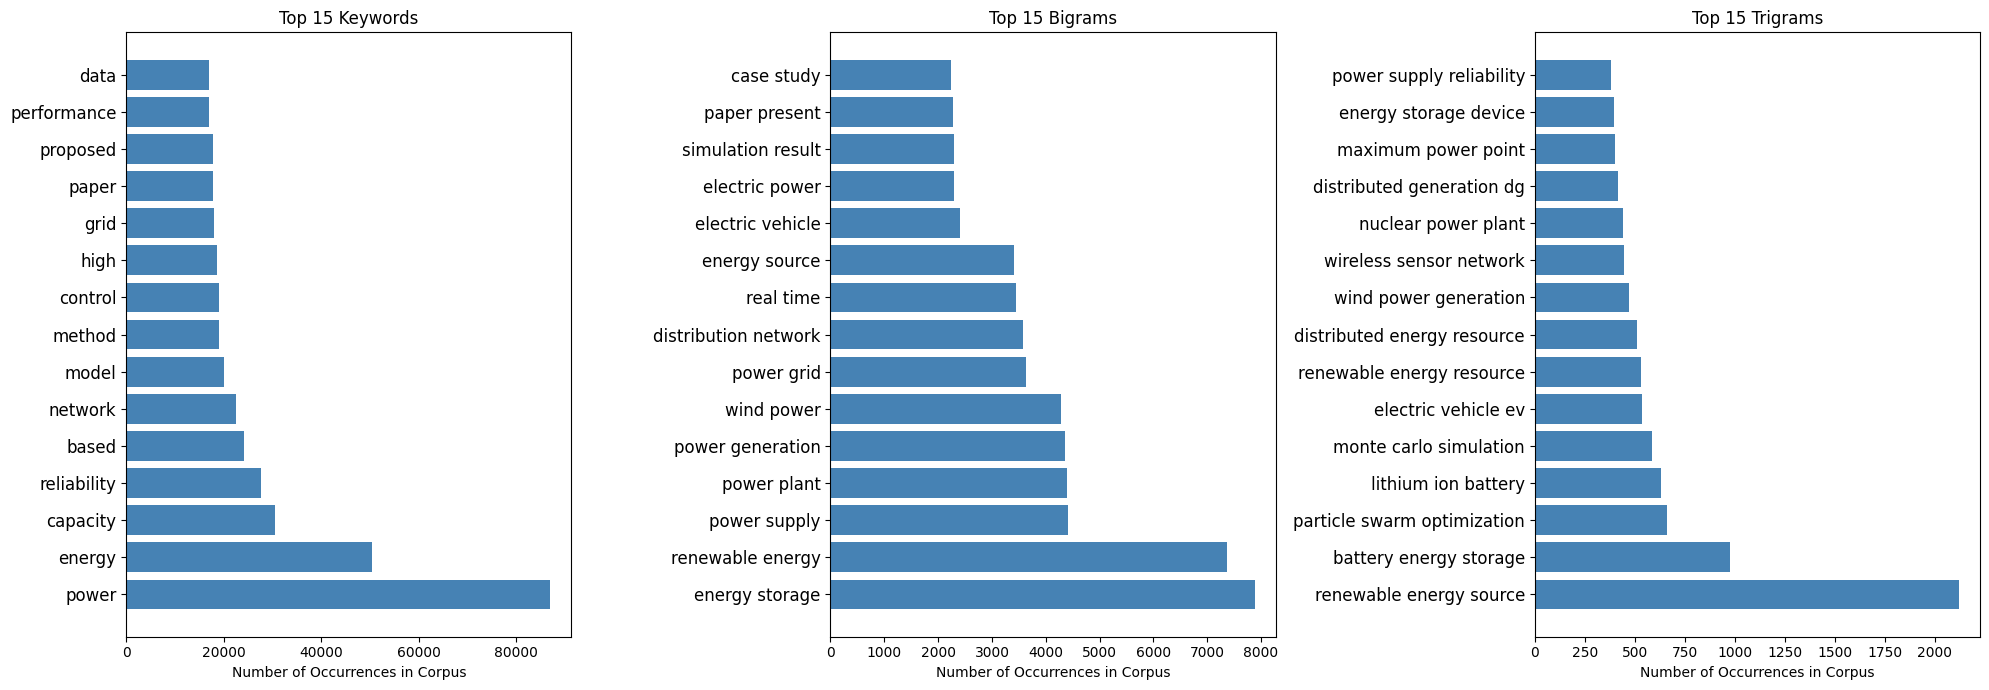

In [ ]:
# Plot global N-grams
plot_term_frequencies(f"term_frequencies_{date_string}.json", n_terms=15, save=True)

### Plot top terms for a topic

Per-topic plot saved as: Saved_files_new\topic_7_Power_System_Reliability_termfrequencies.png


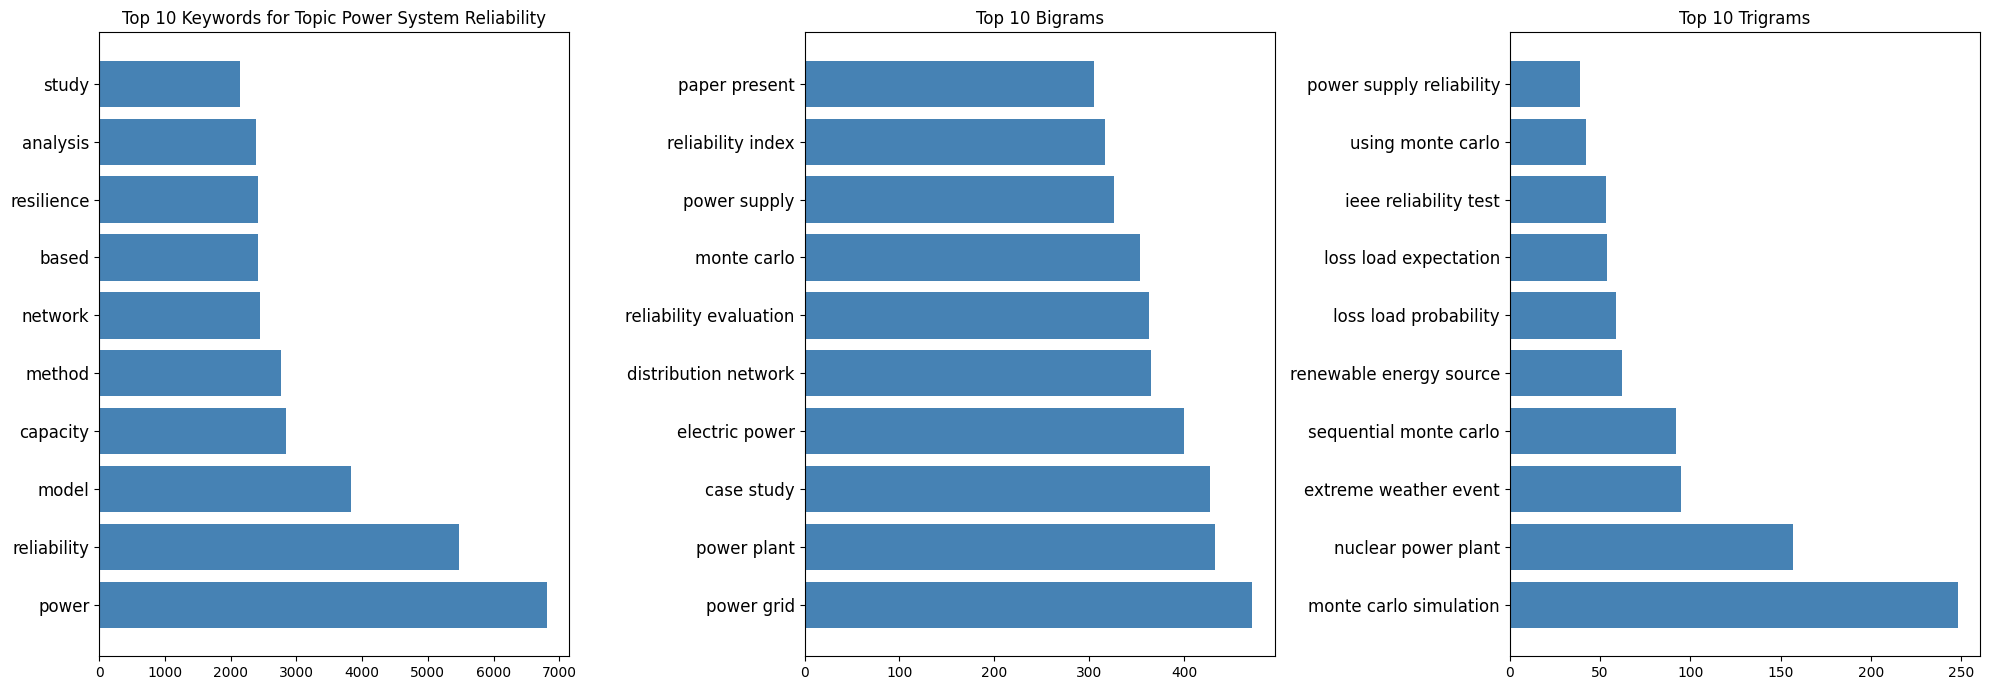

In [ ]:
# Plot top terms for a topic
topic_to_plot = 7
name = topic_names.get(str(topic_to_plot), f"Topic {topic_to_plot}") if topic_names else f"Topic {topic_to_plot}"
plot_top_terms_for_topic(df, topic_to_plot, topic_name=name, save=True)


### Plot method importance

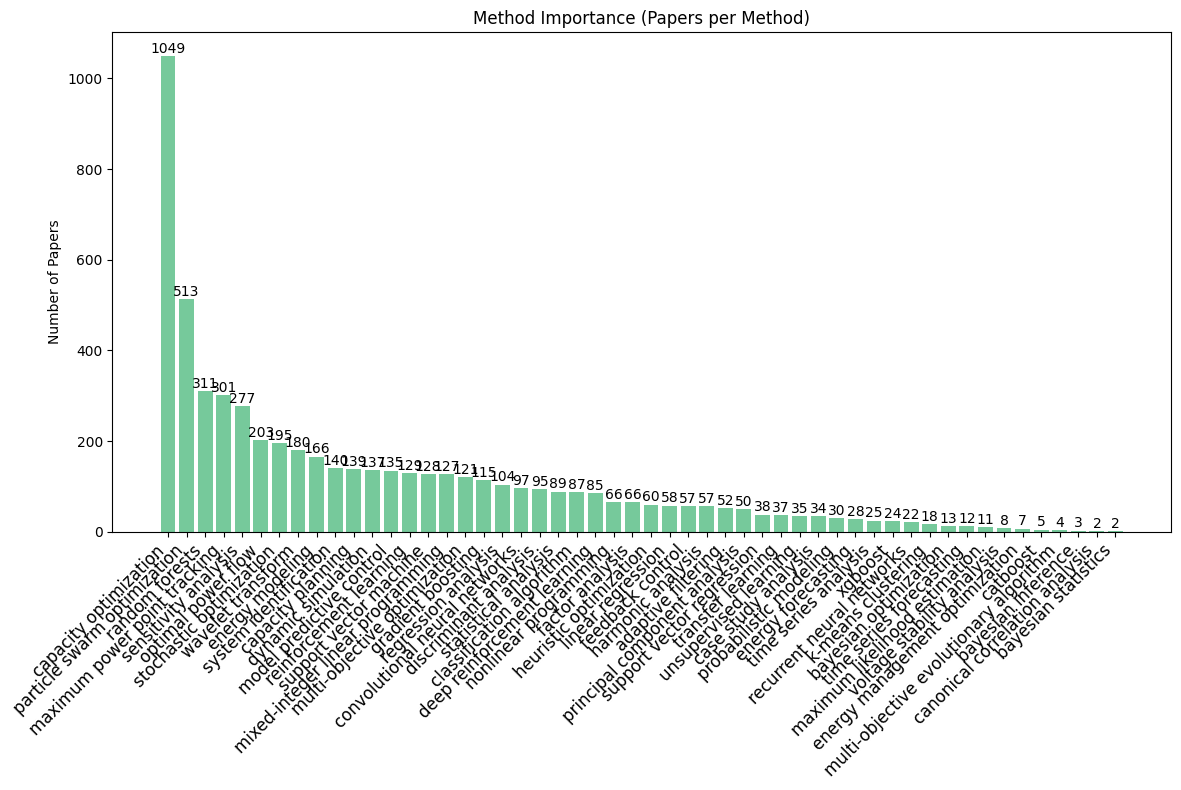

In [ ]:
# Plot method importance
plot_method_importance(df)

### Plot topic importance

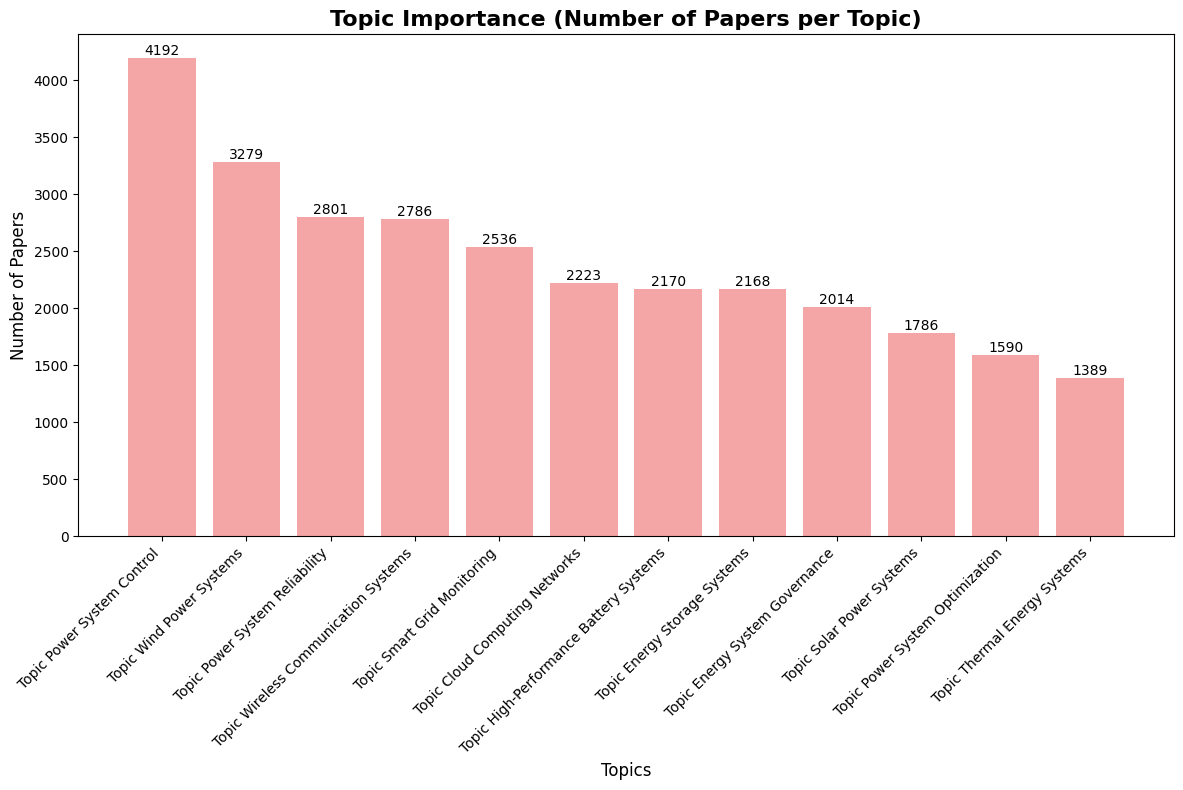

In [ ]:
# Plot topic importance
plot_topic_importance_with_names(df, topic_names)


### Method usage trends

C:\Users\STSI\AppData\Local\Temp\ipykernel_35480\2708704622.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


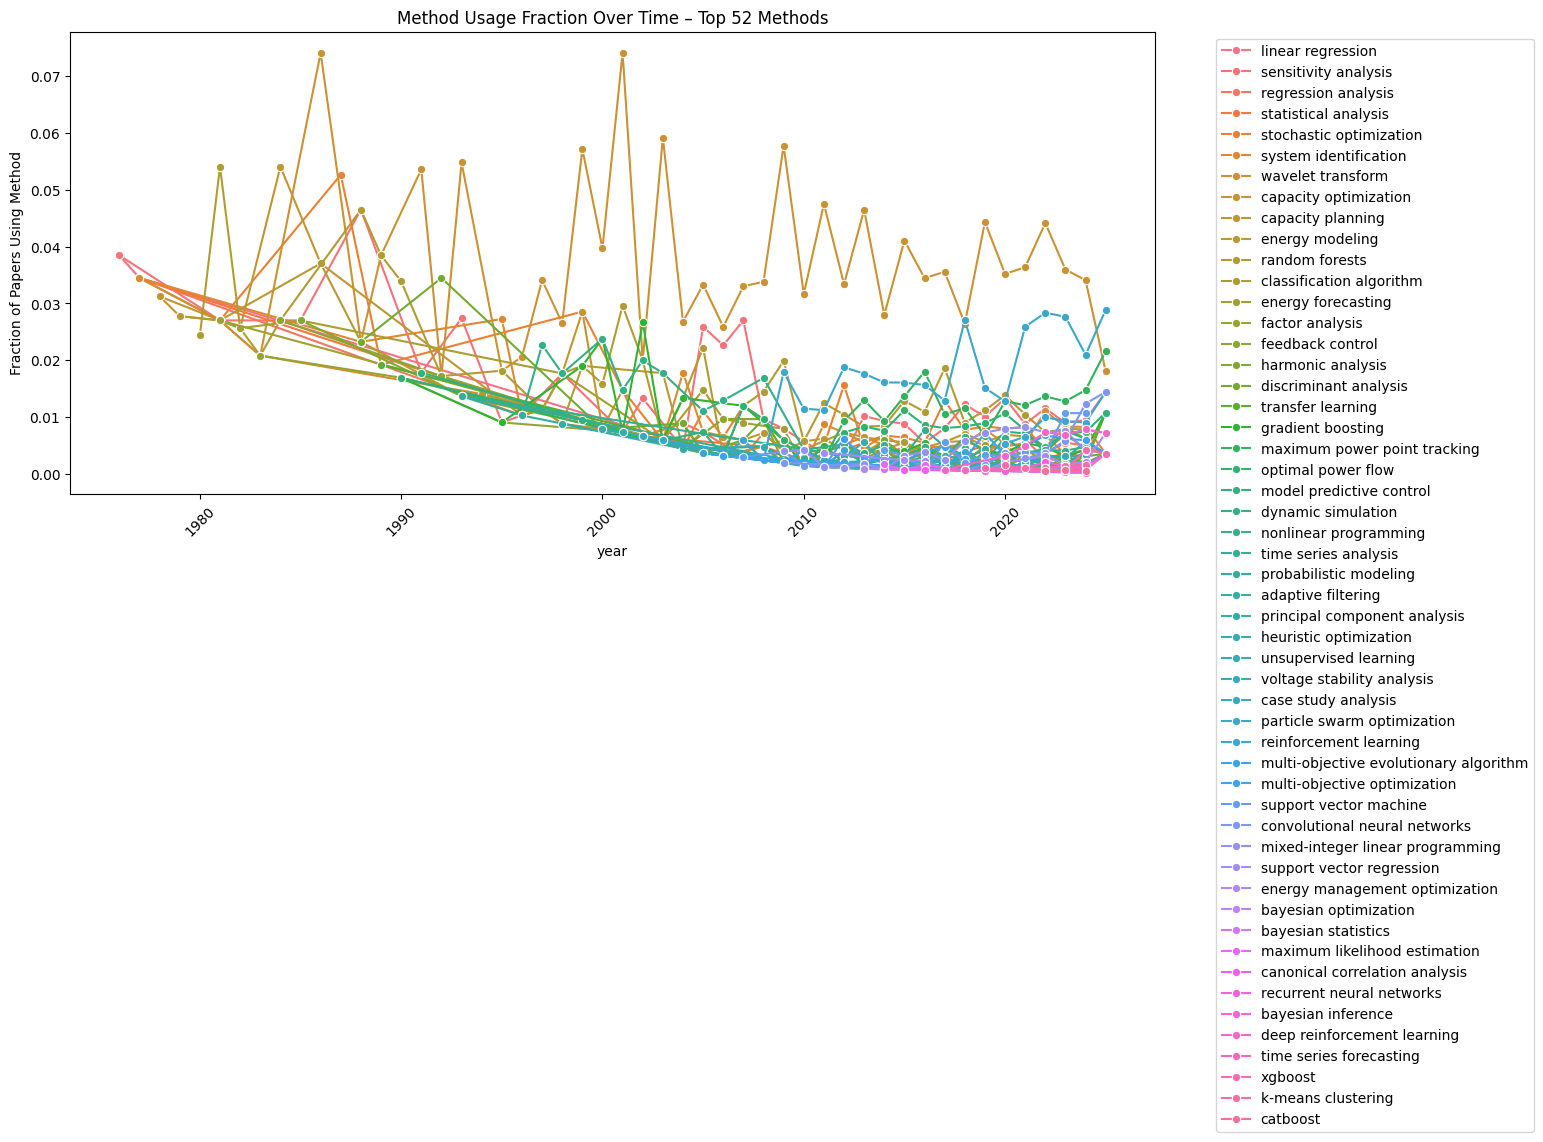

In [ ]:

# Method usage trends (specify methods as list or string)
plot_method_trends_over_time(df)

### Enhanced Method Usage Importance Plot 

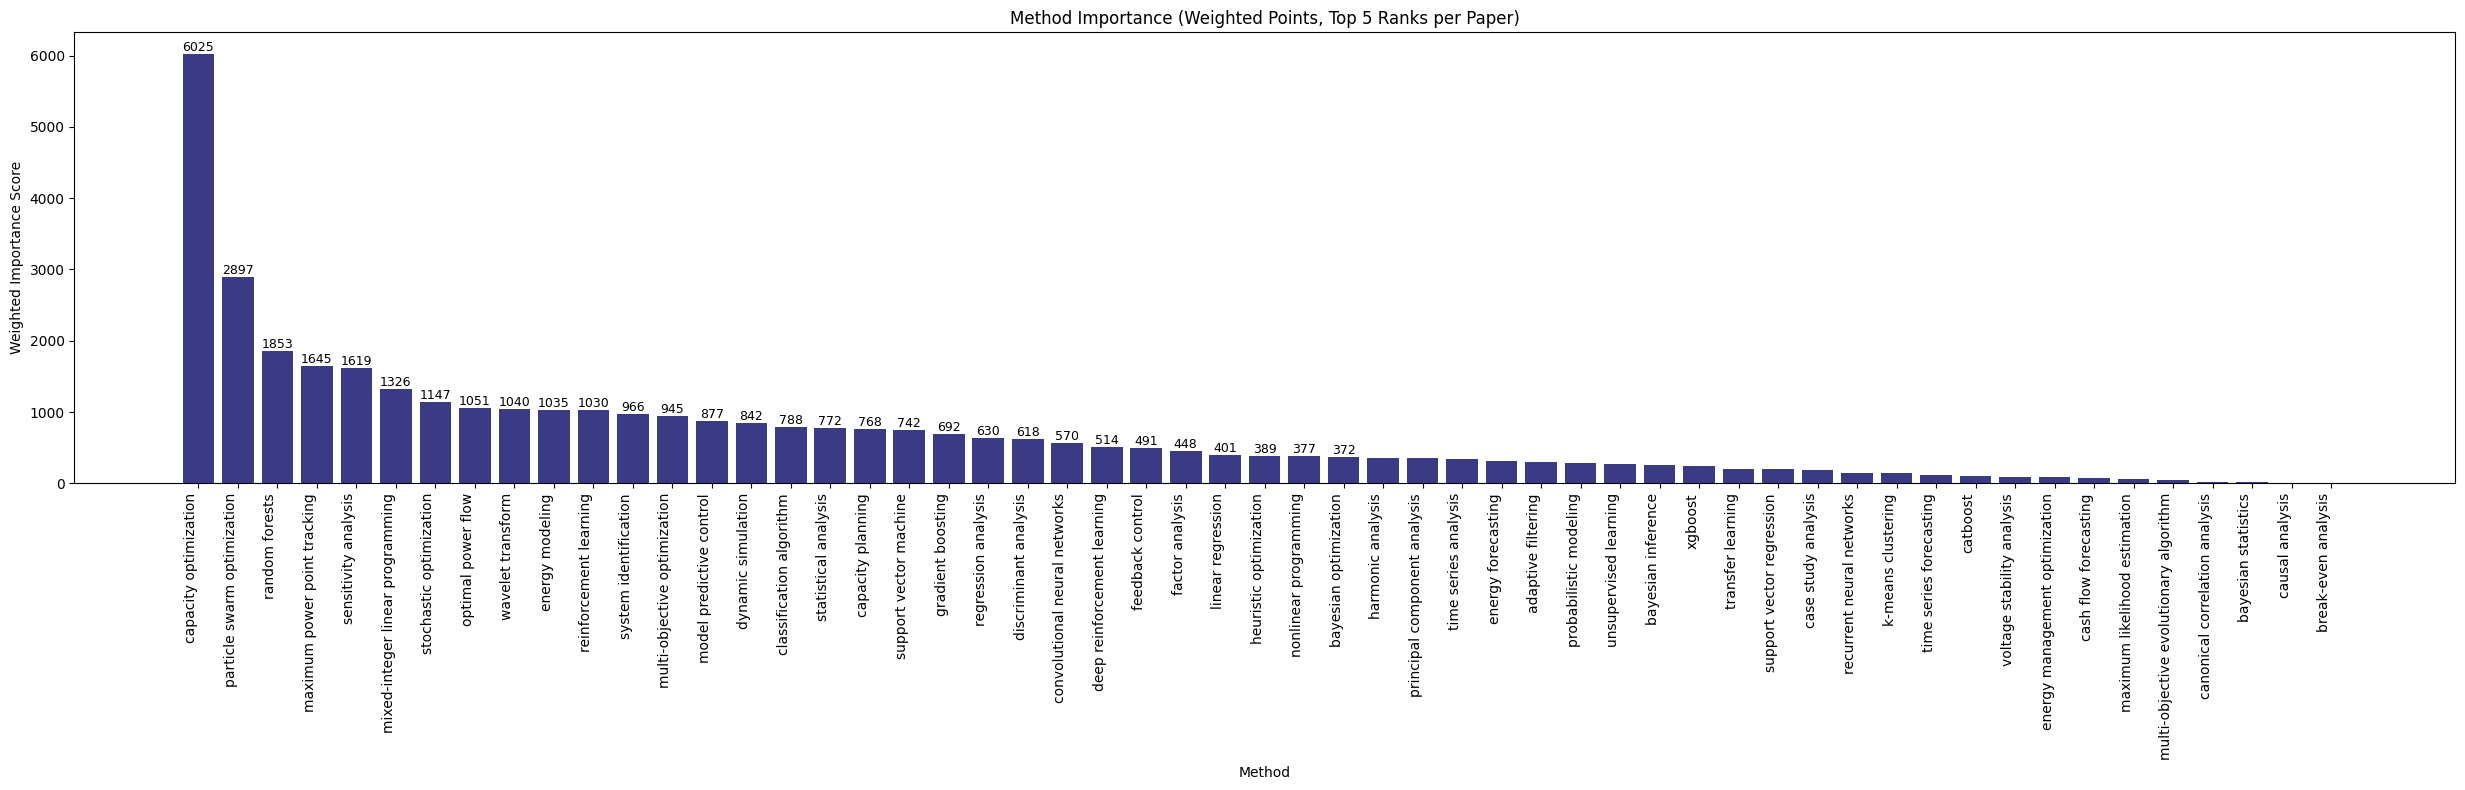

,Method,Points
0,capacity optimization,6025
1,particle swarm optimization,2897
2,random forests,1853
3,maximum power point tracking,1645
4,sensitivity analysis,1619
15,mixed-integer linear programming,1326
6,stochastic optimization,1147
5,optimal power flow,1051
7,wavelet transform,1040
8,energy modeling,1035


In [ ]:
# %%

plot_weighted_method_importance(df, n_top=5)


### Topic usage trends

In [ ]:
# Topic usage trends (specify topics as list or string)
plot_topic_trends_over_time(df, topics=["Power System Optimization"], topic_names=topic_names)

No matching topics to plot.


### Topic-method heatmap

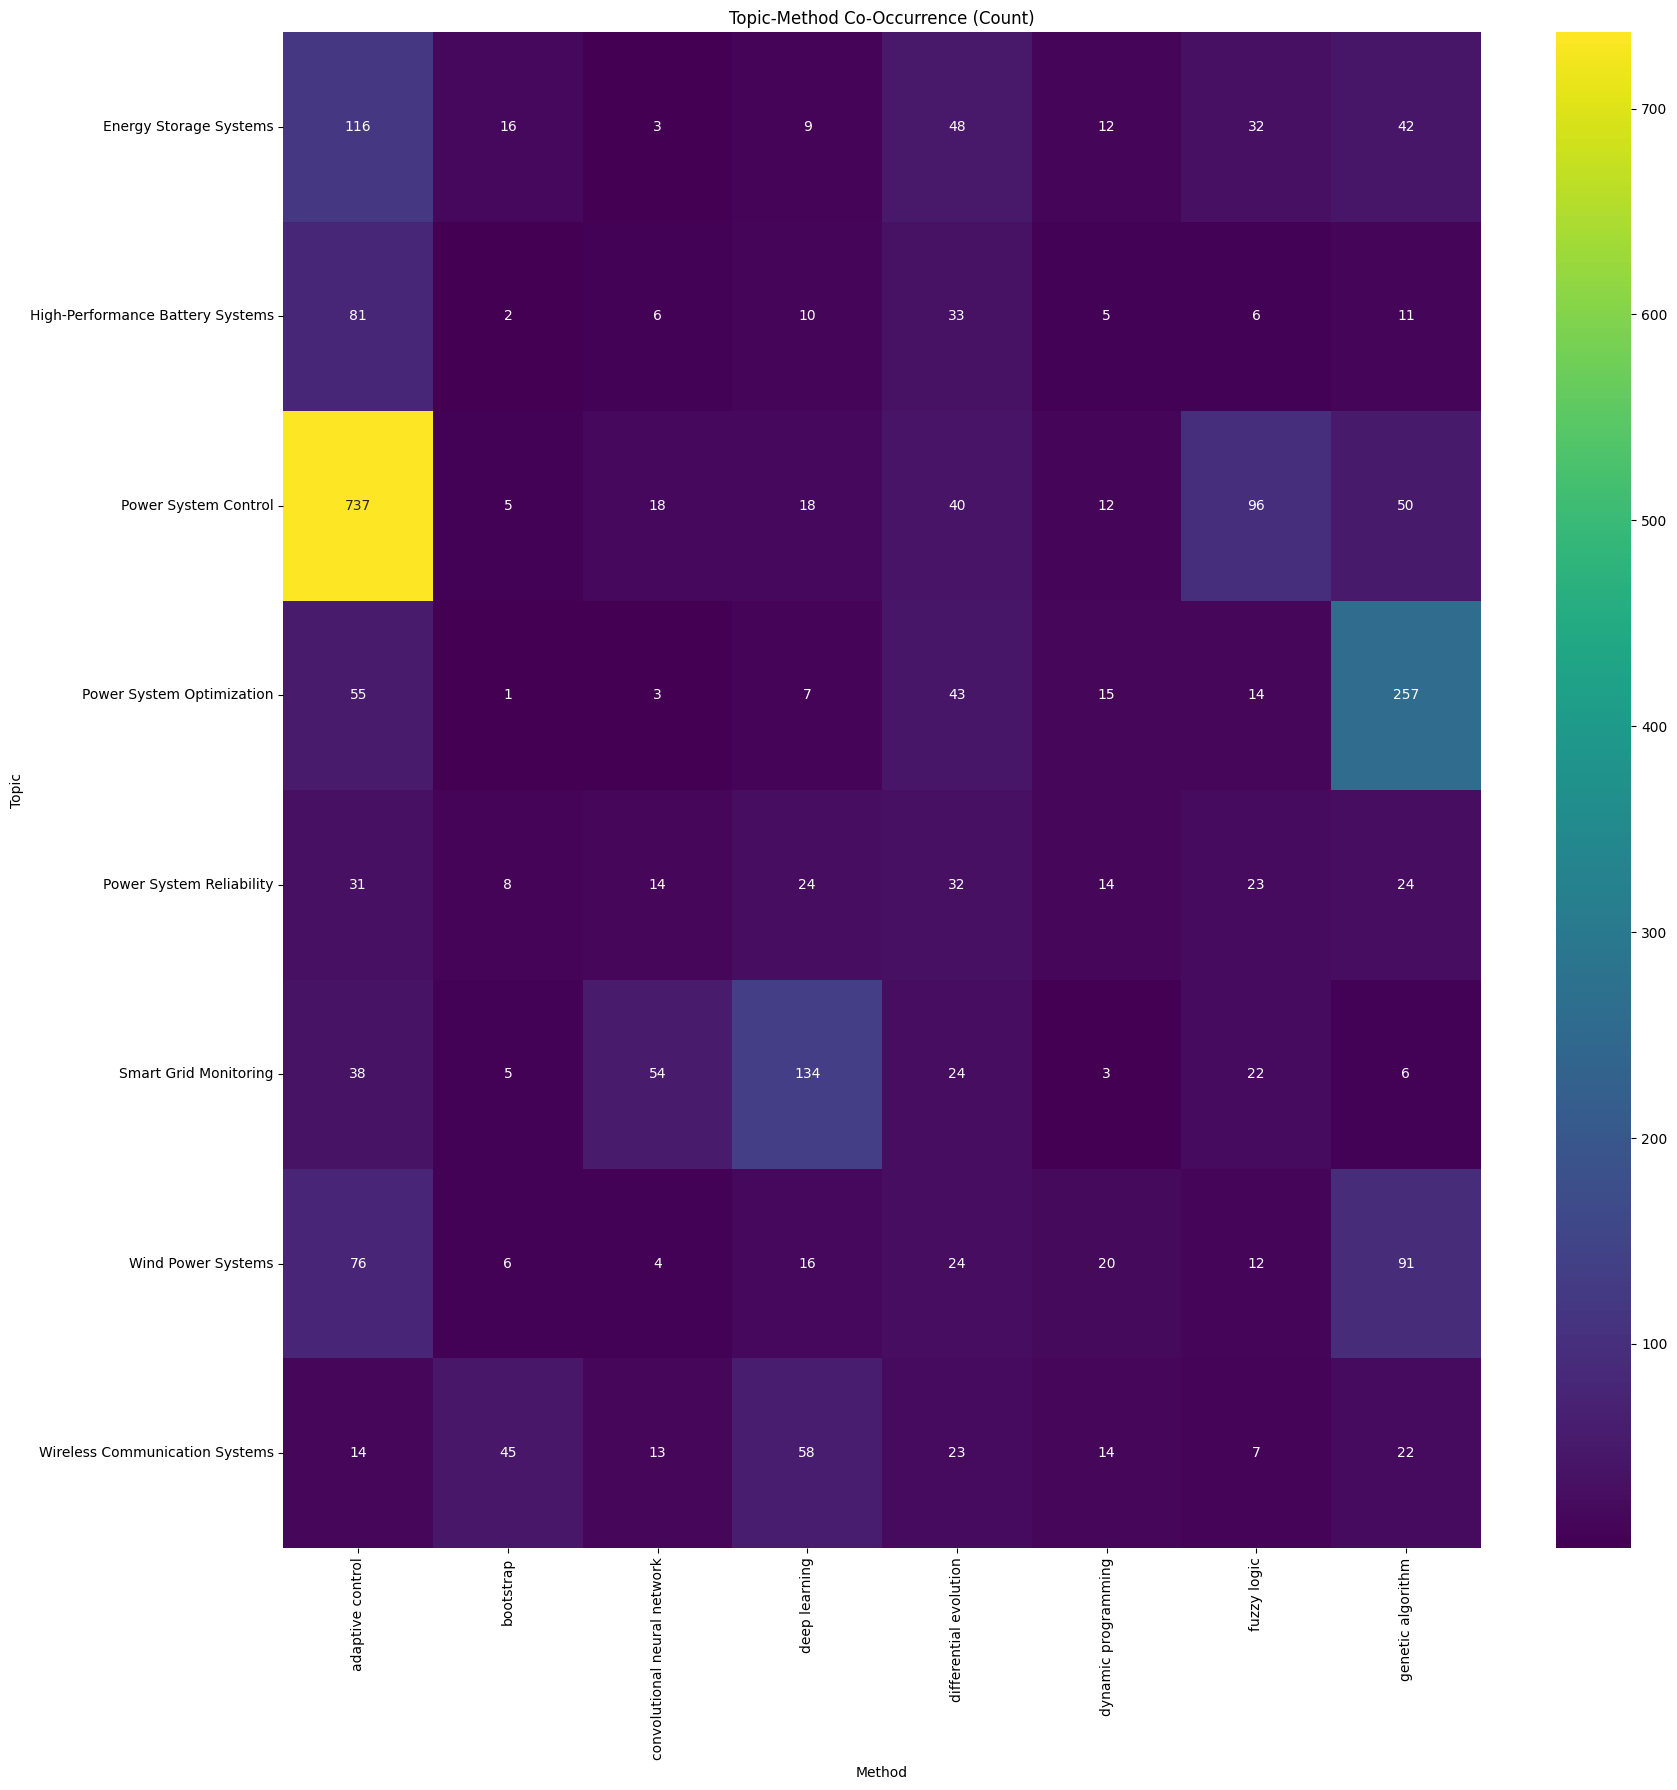

In [ ]:
# Topic-method heatmap
plot_topic_method_heatmap(df)

## More complex plots

### Plot only top 15 methods by weighted score

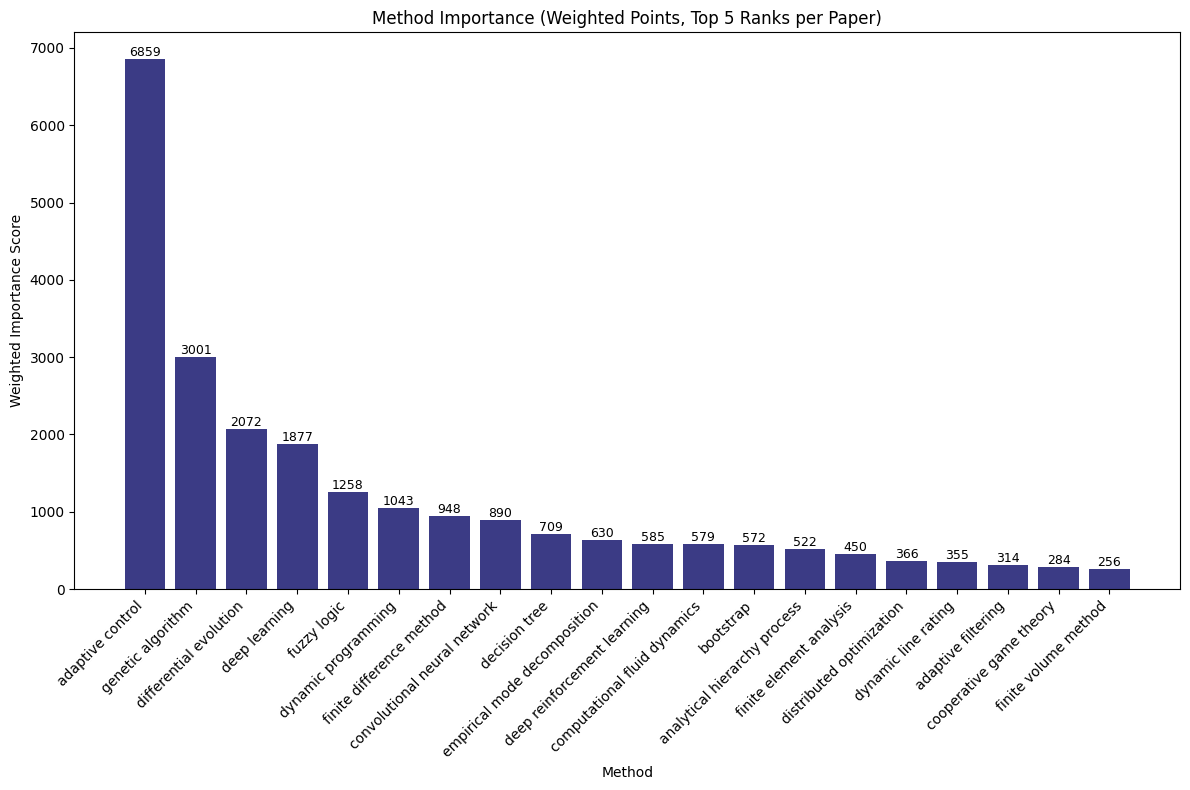

,Method,Points
0,adaptive control,6859
1,genetic algorithm,3001
2,differential evolution,2072
3,deep learning,1877
4,fuzzy logic,1258
6,dynamic programming,1043
17,finite difference method,948
5,convolutional neural network,890
8,decision tree,709
16,empirical mode decomposition,630


In [ ]:
# Plot only top 15 methods by weighted score, using top 5 ranks
plot_weighted_method_importance(df, n_top=5, plot_top_k=25)

### Plot top 8 methods by weighted trend, using top 3 method ranks

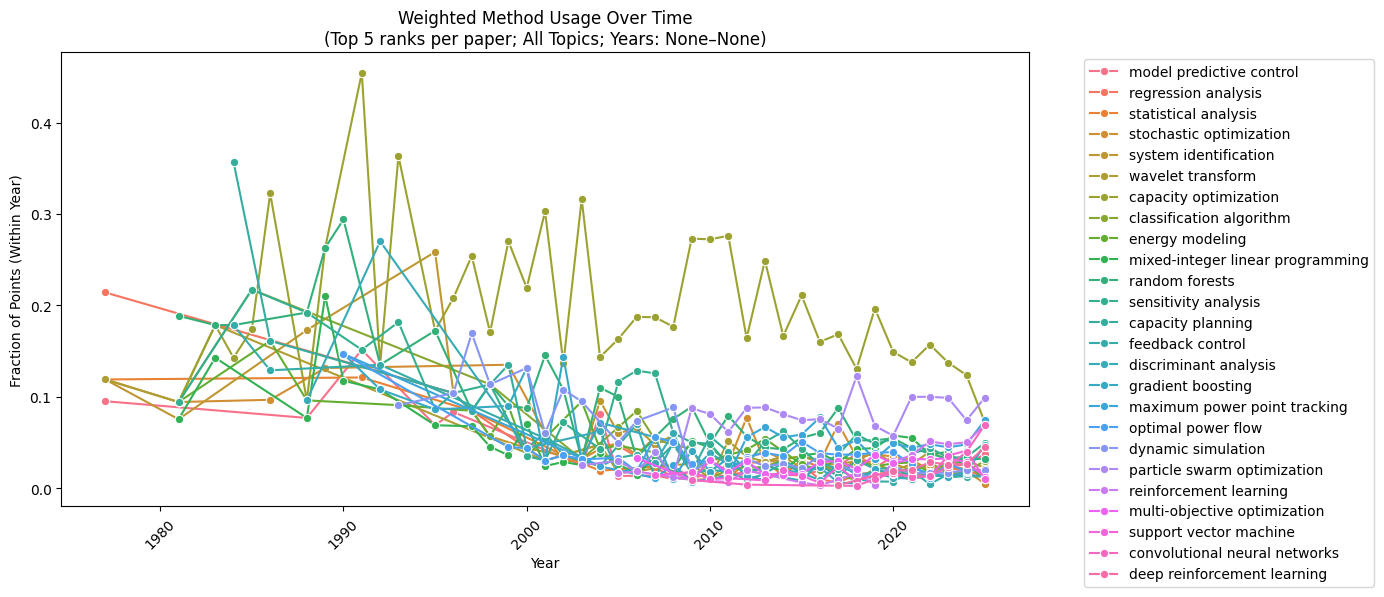

,year,method,points,total_points,fraction
4,1977,model predictive control,4,42,0.095238
5,1977,regression analysis,9,42,0.214286
6,1977,statistical analysis,5,42,0.119048
7,1977,stochastic optimization,5,42,0.119048
8,1977,system identification,5,42,0.119048
...,...,...,...,...,...
1033,2025,sensitivity analysis,20,403,0.049628
1034,2025,statistical analysis,19,403,0.047146
1035,2025,stochastic optimization,2,403,0.004963
1036,2025,support vector machine,4,403,0.009926


In [ ]:
# Plot top 8 methods by weighted trend, using top 3 method ranks
plot_weighted_method_trends_over_time(df, n_top=5, plot_top_k=25)

C:\Users\STSI\AppData\Local\Temp\ipykernel_35480\2404485519.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


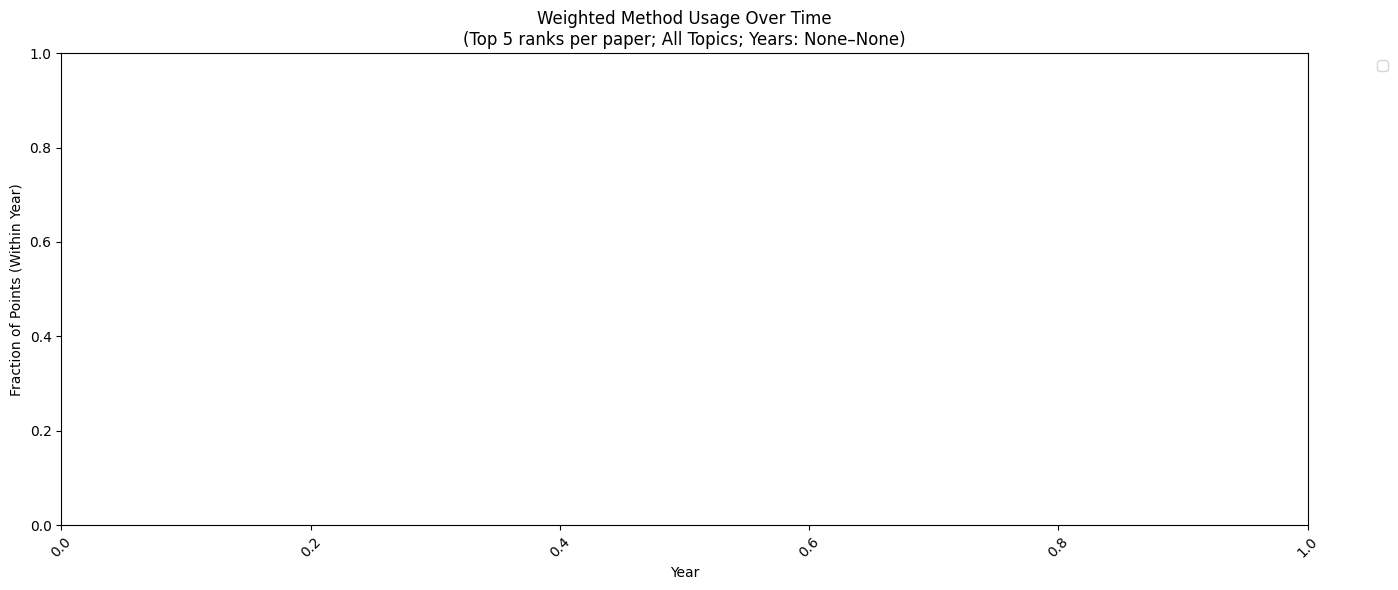

,year,method,points,total_points,fraction


In [ ]:
# Plot specific methods
plot_weighted_method_trends_over_time(df, n_top=5, methods=["monte carlo simulation", "unit commitment"])


### Top 6 N methods and N topics by points

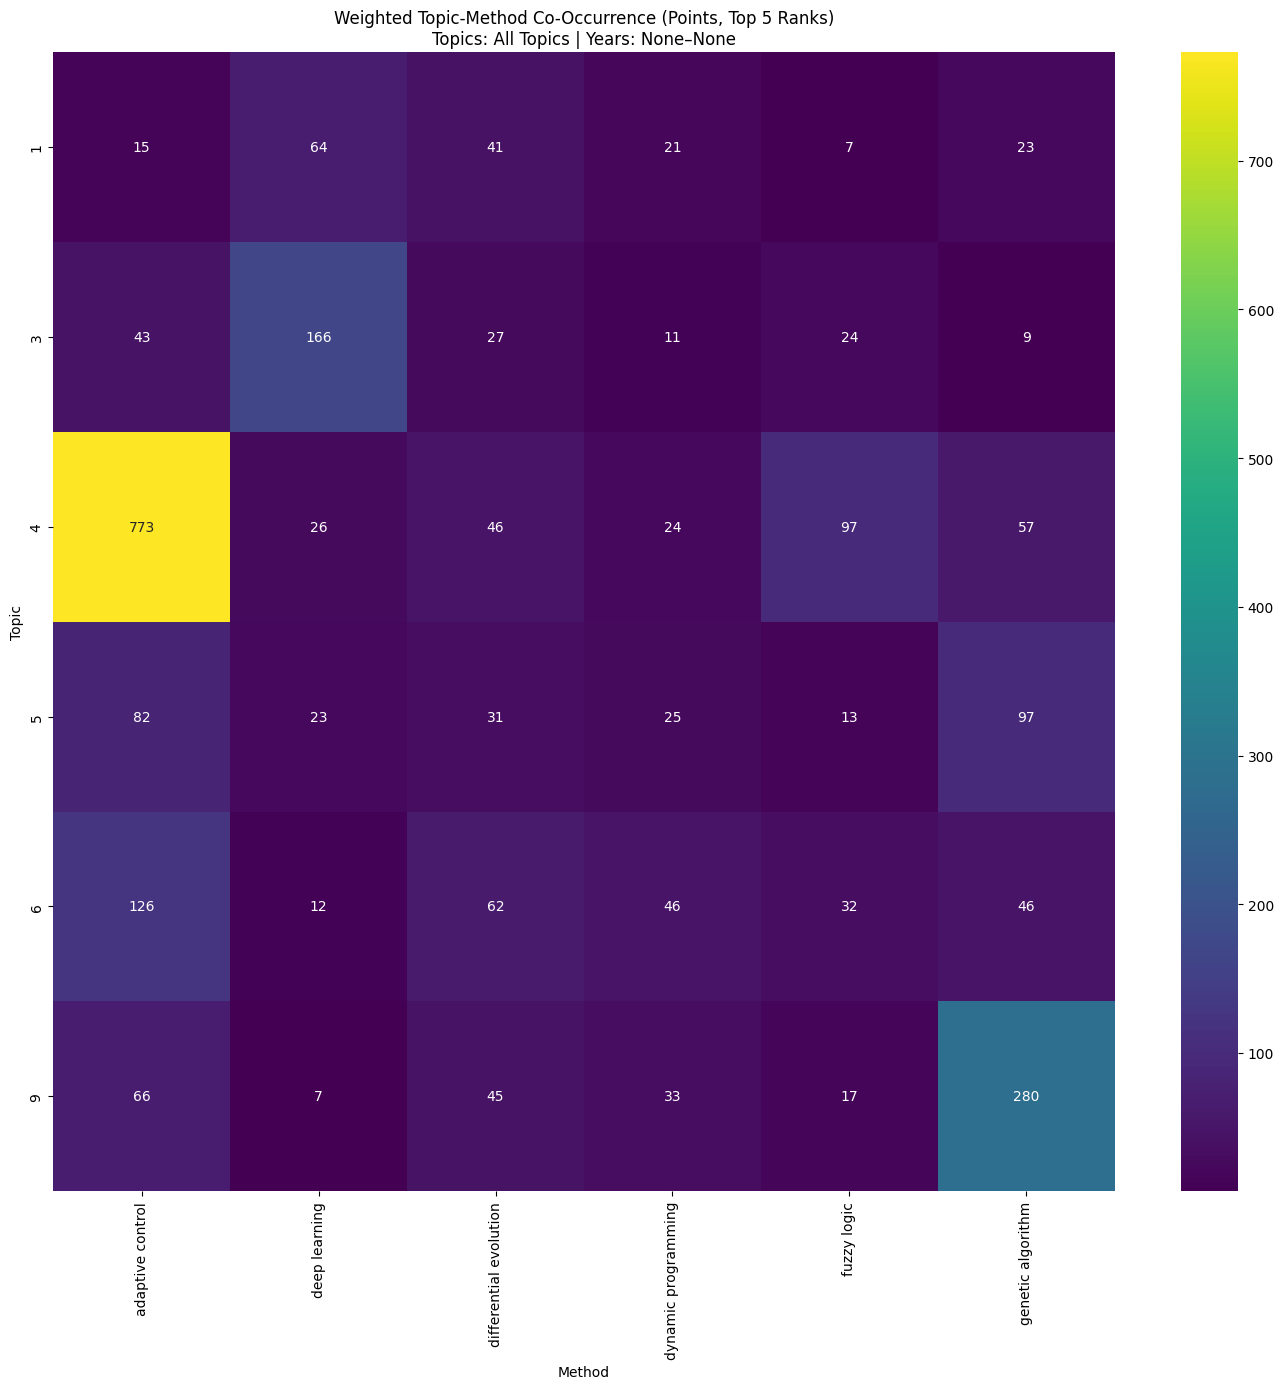

method,adaptive control,deep learning,differential evolution,dynamic programming,fuzzy logic,genetic algorithm
topic,,,,,,
1,15,64,41,21,7,23
3,43,166,27,11,24,9
4,773,26,46,24,97,57
5,82,23,31,25,13,97
6,126,12,62,46,32,46
9,66,7,45,33,17,280


In [ ]:
# Top 6 methods and 6 topics by points
plot_weighted_topic_method_heatmap(df, n_top=5, plot_top_methods=6, plot_top_topics=6)


### # Trend for topics 0, 3, and 5

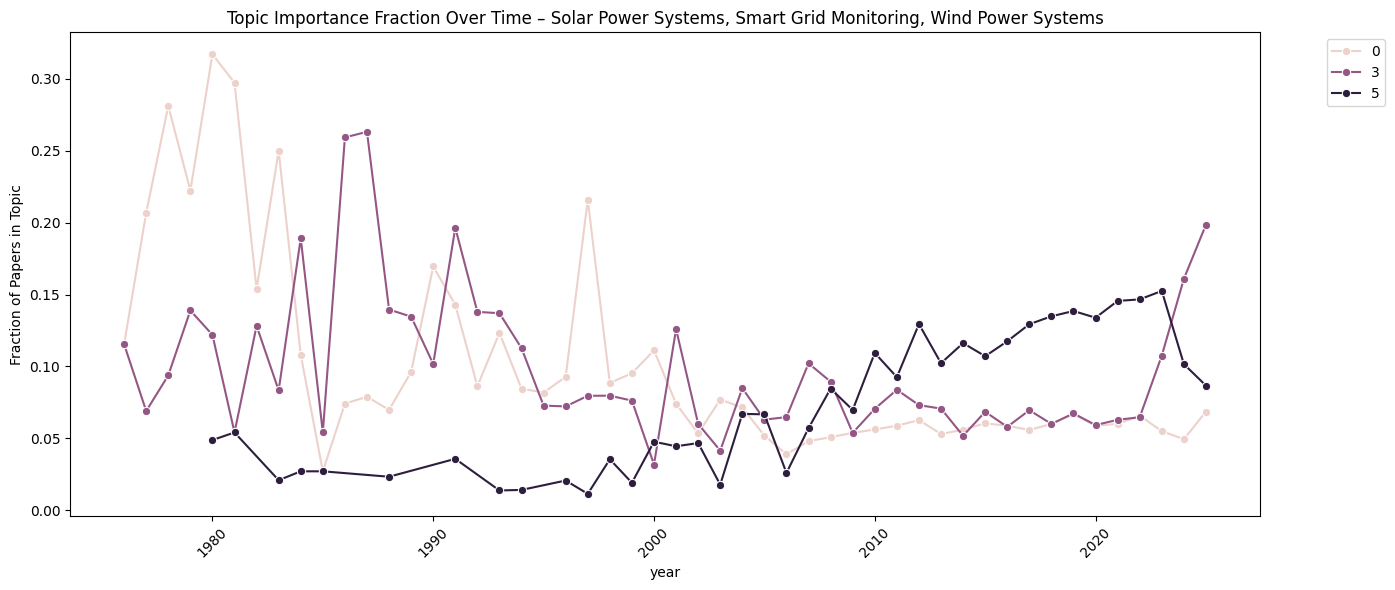

In [ ]:
# Trend for topics 0, 3, and 5
plot_topic_trends_over_time(df, topics=[0,3,5], topic_names=topic_names)


### Method trends for selected topics

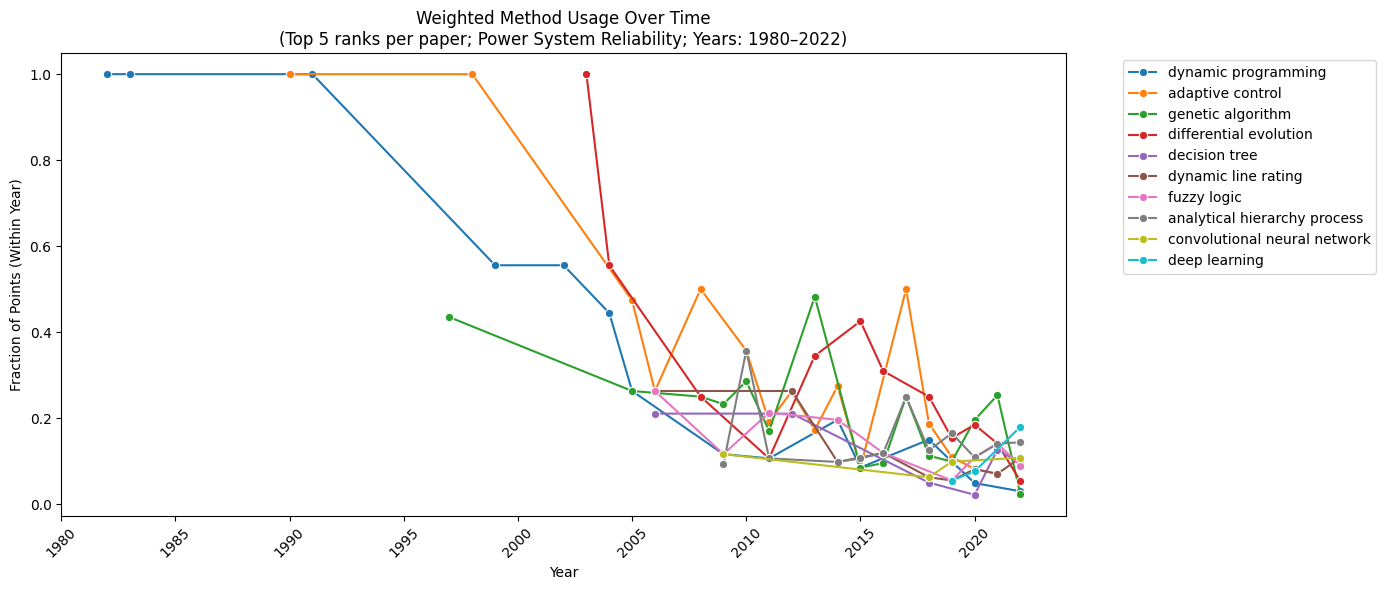

,year,method,points,total_points,fraction
0,1982,dynamic programming,5,5,1.000000
1,1983,dynamic programming,5,5,1.000000
2,1990,adaptive control,5,5,1.000000
3,1991,dynamic programming,5,5,1.000000
6,1997,genetic algorithm,10,23,0.434783
...,...,...,...,...,...
116,2022,differential evolution,9,167,0.053892
117,2022,dynamic line rating,18,167,0.107784
118,2022,dynamic programming,5,167,0.029940
121,2022,fuzzy logic,15,167,0.089820


In [ ]:
# Plot method trends for topic 4 only, with proper years and at least 10 papers/year shown
plot_weighted_method_trends_over_time(
    df, n_top=5, topics=[7], topic_names=topic_names,
    start_year=1980, end_year=2022, year_col='year', min_papers_per_year=1, plot_top_k=10
)

### Topic to methods correlation heatmap

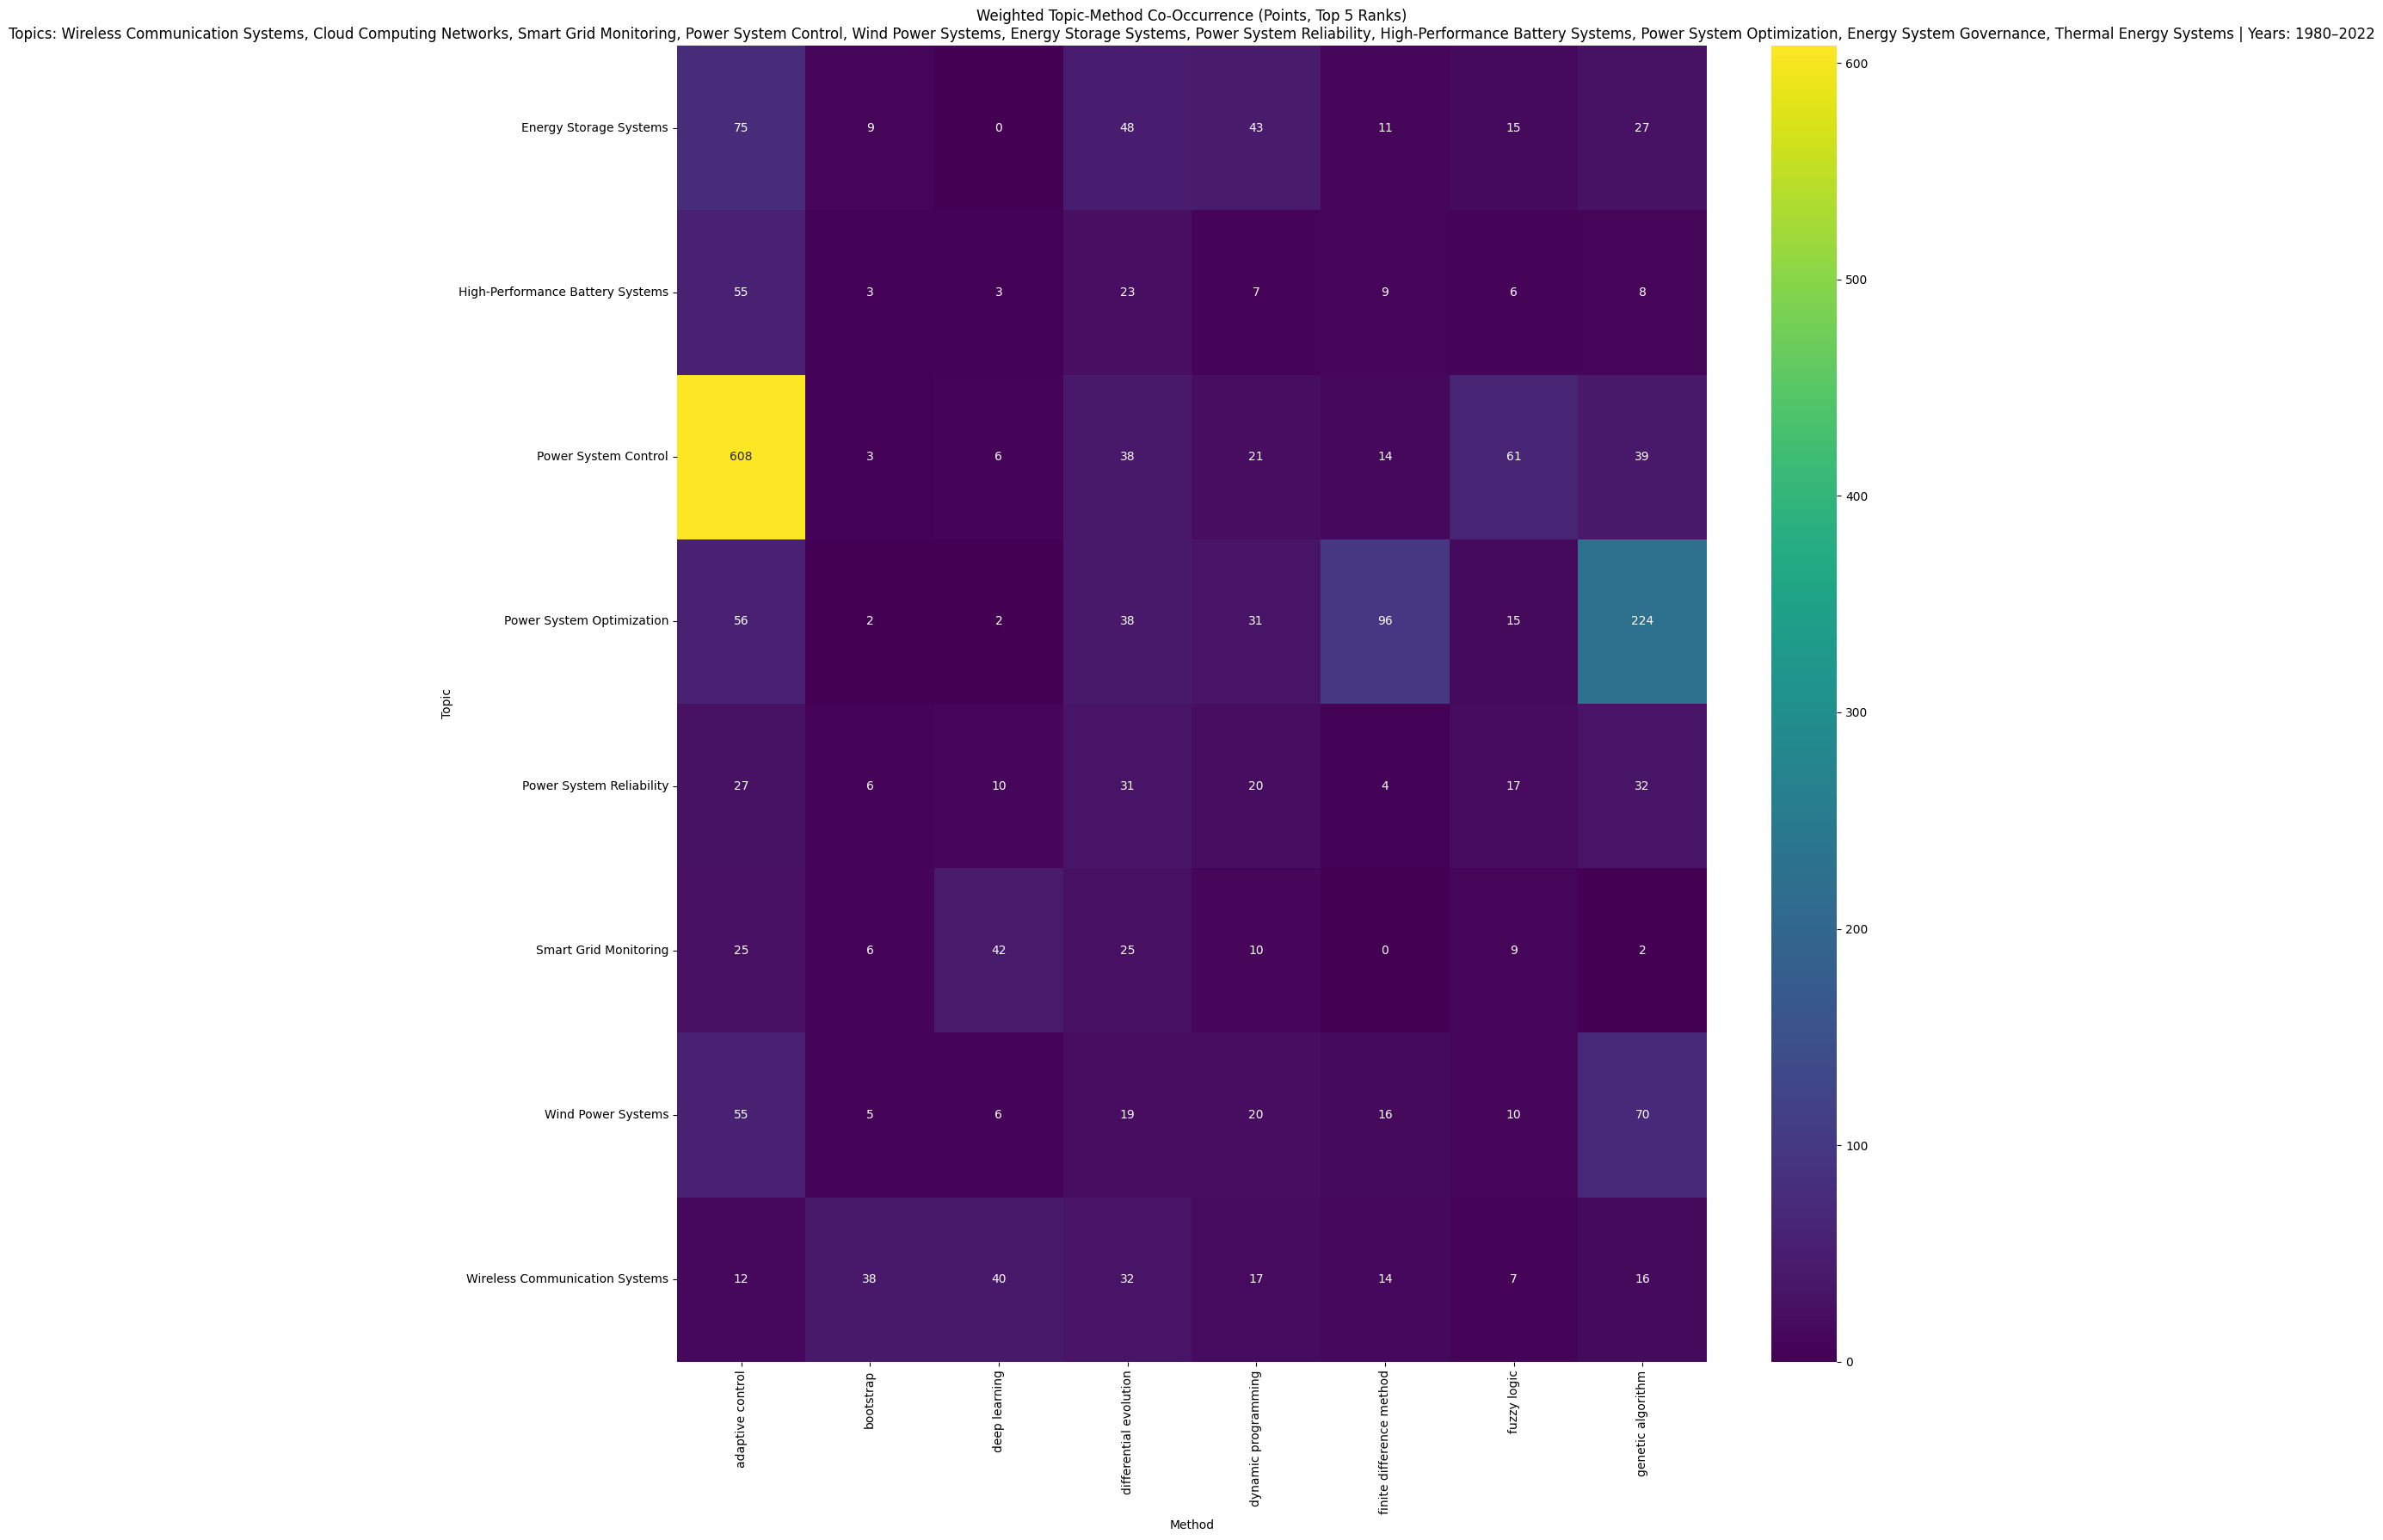

In [ ]:
# Plot correlation heatmap for topics 4 and 2, with topic names as labels and years 2000–2022 only
pivot = plot_weighted_topic_method_heatmap(
    df, n_top=5, topics=[1,2,3,4,5,6,7,8,9,10,11], topic_names=topic_names,
    start_year=1980, end_year=2022, year_col='year', min_papers_per_year=10
)